In [1]:
import numpy as np

import qutip as qt
import torch
from torch.utils.data import Dataset, DataLoader
import joblib

import torch.nn as nn
import matplotlib.pyplot as plt

from torch import tensor

from tqdm.notebook import tqdm
import torch_optimizer as topt

In [2]:
df = joblib.load("weak_coupling_dataset_bloch.job")

In [3]:
df.keys()

dict_keys(['lambda', 'gamma_0', 'times', 'Initial_rhos', 'povm_arr', 'prob arr'])

In [4]:
times = df["times"]
raw_data = tensor(df["prob arr"].real)
raw_data = raw_data[
    ::10, 0:4000, :
]  # We don't need so many data in the mixed state

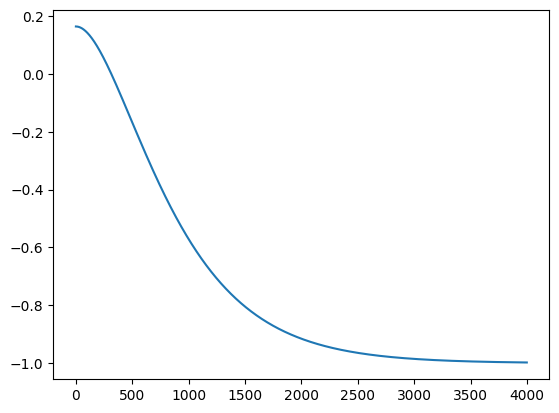

In [5]:
plt.plot(raw_data[0, :, 2])

In [6]:
sigma_vec = tensor(
    np.array([qt.sigmax(), qt.sigmay(), qt.sigmaz()]), dtype=torch.complex64
)


def rho_to_bloch(rho):
    torch.einsum("kl, ilk-> i", rho, sigma_vec)


def bloch_to_rho(v):
    real_part = 0.5 * (
        torch.eye(2) + torch.einsum("i, ilk", v, sigma_vec.real)
    )
    imag_part = 0.5 * (torch.einsum("i, ilk", v, sigma_vec.imag))
    return real_part + 1j * imag_part


def vec(rho):
    return rho.flatten()

In [7]:
def dag(A):
    return np.conjugate(A.T)


def sprepost(A, B):
    return np.kron(A, np.transpose(B))


def spre(A):
    return sprepost(A, np.identity(2))


def spost(A):
    return sprepost(np.identity(2), A)

In [8]:
spsm = qt.sigmap() * qt.sigmam()
sp = np.array(qt.sigmap().full())
sm = np.array(qt.sigmam().full())

spsm = np.array(spsm.full())

unitary_super = tensor(-1j / 2 * (spre(spsm) - spost(spsm)))

dissipative_super = tensor(
    sprepost(sm, dag(sm)) - 0.5 * (spre(sp @ sm) + spost(sp @ sm))
)

make_L = lambda S, gamma: S * unitary_super + gamma * dissipative_super

In [9]:
# The output of the network must be two numbers S, gamma.

# then, we need to take the last input, we conver to rho, we vectorize,
# generate the lindbladian, exponentiate it, multiply by delta t (optionally)
# and convert to bloch again

In [69]:
raw_data[0, 0]
vec_rho_i = vec(bloch_to_rho(raw_data[0, 0]))
L = make_L(0, 0.3)
rho_hat = torch.linalg.matrix_exp(L).type(torch.complex64) @ vec_rho_i
v_hat = rho_to_bloch(rho_hat.reshape(2, 2))

In [10]:
def create_windowed_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + lookback]
        X.append(feature)
        y.append(target)
    return torch.stack(X), torch.stack(y)

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

# nope,
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [12]:
raw_data = raw_data.swapaxes(1, 2)

In [13]:
raw_data.shape

torch.Size([100, 3, 4000])

In [26]:
num_epochs = 4000  # Number of training epochs
N = raw_data.shape[0]
C = raw_data.shape[1]
L = raw_data.shape[2]

no_filters = 64

kernel_window = 15

number_of_features = 3  # Three components of the bloch vector

torch.autograd.set_detect_anomaly(False)

opt_list = [torch.optim.Adam]

In [27]:
coarse_graining_size = 25

X_raw = raw_data[:, :, ::coarse_graining_size][:, :, :]
y_raw = raw_data[:, :, ::coarse_graining_size][:, :, :][
    :, :, kernel_window - 1 :
]


X_raw_windowed, y_raw_windowed = torch.vmap(
    lambda df: create_windowed_dataset(df, lookback=kernel_window)
)(tensor(raw_data[:, :, ::coarse_graining_size].swapaxes(1, 2)))


X_raw_windowed = X_raw_windowed.swapaxes(2, 3)

/var/folders/l8/76nz7vj14k5_137qc0yjdc1m0000gn/T/ipykernel_38219/721559039.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )(tensor(raw_data[:, :, ::coarse_graining_size].swapaxes(1, 2)))


In [28]:
X_raw_windowed_merged_trajs = X_raw_windowed.reshape(
    -1, number_of_features, kernel_window
)

y_raw_windowed_merged_trajs = y_raw_windowed.reshape(-1, number_of_features)

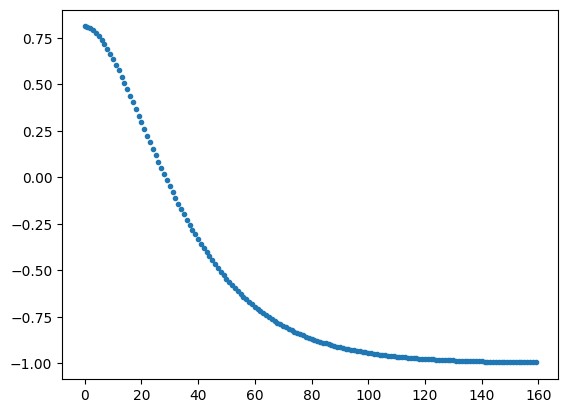

In [29]:
plt.plot(raw_data[16, 2, ::coarse_graining_size], ".")

In [30]:
print(X_raw.shape)
print(X_raw_windowed.shape)
print(X_raw_windowed_merged_trajs.shape)
print("\n")
print(y_raw.shape)
print(y_raw_windowed.shape)
print(y_raw_windowed_merged_trajs.shape)

torch.Size([100, 3, 160])
torch.Size([100, 145, 3, 15])
torch.Size([14500, 3, 15])


torch.Size([100, 3, 146])
torch.Size([100, 145, 3])
torch.Size([14500, 3])


In [123]:
sigma_vec = tensor(
    np.array([qt.sigmax(), qt.sigmay(), qt.sigmaz()]), dtype=torch.complex64
)


def evolve_last_timestep(bloch_vec_to_evolve, S, gamma):
    vec_rho_i = vec(bloch_to_rho(bloch_vec_to_evolve))

    L = make_L(S, gamma)
    rho_hat = torch.linalg.matrix_exp(L).type(torch.complex64) @ vec_rho_i
    print(rho_hat.reshape(2, 2).dtype)
    v_hat = rho_to_bloch(rho_hat.reshape(2, 2))
    print(v_hat)
    return rho_hat


class CNNDensityMatrixEvolveLindblad(nn.Module):
    def __init__(
        self, no_channels, no_filters, kernel_window, timeseries_length=None
    ):
        super(CNNDensityMatrixEvolveLindblad, self).__init__()
        self.kernel_window = kernel_window
        self.conv1 = nn.Conv1d(
            in_channels=no_channels,
            out_channels=no_filters,
            kernel_size=kernel_window,
        )
        # self.fc0 = nn.Linear(kernel_window*no_channels, no_filters)
        self.fc1 = nn.Linear(no_filters, 128)
        self.fc2 = nn.Linear(128, 64)

        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)
        self.sigma_vec = sigma_vec.to(device)

    def bloch_to_rho(self, v):
        real_part = 0.5 * (
            torch.eye(2).to(device)
            + torch.einsum("i, ilk", v, self.sigma_vec.real).to(device)
        ).type(torch.complex64)
        imag_part = 0.5 * (torch.einsum("i, ilk", v, self.sigma_vec.imag)).to(
            device
        ).type(torch.complex64)
        return real_part + 1j * imag_part

    def evolve_last_timestep(self, network_output, S, gamma):
        last_v = network_output[:, -1]
        vec_rho_i = vec(self.bloch_to_rho(last_v))
        L = make_L(S, gamma)
        rho_hat = torch.linalg.matrix_exp(L).type(torch.complex64) @ vec_rho_i
        return torch.einsum("ijk, kj", self.sigma_vec, rho_hat.reshape(2, 2))

    def forward(self, x):
        # x is of shape torch.Size([batch_size, num_features, kernel_window])

        # Apply convolution to the window
        aux = self.conv1(x).squeeze(-1)
        aux = nn.ReLU()(aux)
        # print(x.shape)
        # aux = self.fc0(x.flatten(-1))
        # aux = nn.ReLU()(aux)
        # Permute and apply fully connected layer
        # print(aux.shape)
        aux = self.fc1(aux)
        aux = nn.ReLU()(aux)
        aux = self.fc2(aux)
        aux = nn.ReLU()(aux)
        aux = self.fc3(aux)
        aux = nn.ReLU()(aux)
        aux = self.fc4(aux)
        evolved_bloch = torch.vmap(self.evolve_last_timestep)(
            x, aux[:, 0], aux[:, 1]
        )
        return evolved_bloch.real
        # Squeeze the last dimension to remove the window size
        # output = aux.squeeze(-1)
        return aux


class DensityMatrixDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (self.X[idx], self.y[idx])
        return sample

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_raw_windowed_merged_trajs,
    y_raw_windowed_merged_trajs,
    test_size=0.2,
    random_state=42,
)

In [125]:
X_train.shape

torch.Size([11600, 3, 15])

In [126]:
def generate_sequence(model, initial_window, sequence_length):
    """
    Generates a sequence of the specified length using the given model and initial window.

    Args:
        model (YourModel): The trained model instance.
        initial_window (torch.Tensor): The initial window to start generating the sequence.
                                       Shape should be (batch_size, num_features, kernel_window).
        sequence_length (int): The total length of the sequence to be generated.

    Returns:
        torch.Tensor: The generated sequence of shape (batch_size, num_features, sequence_length).
    """
    batch_size, num_features, kernel_window = initial_window.shape
    # Preallocate output tensor with the correct size
    final_output = torch.empty(
        (batch_size, num_features, sequence_length),
        device=initial_window.device,
    )

    # Fill in the initial part of the output sequence
    final_output[:, :, :kernel_window] = initial_window

    # Generate the rest of the sequence
    current_window = initial_window
    for i in range(sequence_length - kernel_window):
        # Get the model output for the current window
        output = model(current_window)

        # Place the output in the preallocated tensor
        final_output[:, :, i + kernel_window] = output

        # Update the current window by sliding one step forward
        current_window = torch.cat(
            (current_window[:, :, 1:], output.unsqueeze(-1)), dim=2
        )

    return final_output

In [127]:
dataset = DensityMatrixDataset(X_train, y_train)
dataloader = DataLoader(
    dataset, batch_size=int(len(X_train) / 2), shuffle=True
)

test_dataset = DensityMatrixDataset(X_val, y_val)
test_dataloader = DataLoader(
    test_dataset, batch_size=int(len(X_val) / 2), shuffle=True
)


model = CNNDensityMatrixEvolveLindblad(
    no_channels=C,
    no_filters=no_filters,
    kernel_window=kernel_window,
    timeseries_length=L,
)

model = model.to(device)


criterion = lambda y_hat, y_true: nn.L1Loss()(y_hat, y_true) + nn.MSELoss()(
    y_hat, y_true
)

optimizer = topt.DiffGrad(model.parameters(), lr=0.01)

In [128]:
print(model)

CNNDensityMatrixEvolveLindblad(
  (conv1): Conv1d(3, 64, kernel_size=(15,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)


In [129]:
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(dataloader))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=200, verbose=True, threshold=1e-16
)
progress_bar = tqdm(range(num_epochs), desc="Epoch")
minloss = 100
for epoch in progress_bar:
    running_loss = 0.0
    # progress_bar_epoch = tqdm(dataloader, desc='Batch')
    for i, data in enumerate(dataloader):
        X, y_true = data
        # y_true = X
        X = X.to(device)
        y_true = y_true.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        y_hat = model(X)

        # y_hat = generate_sequence(model, X[:,:,:kernel_window], X.shape[2])

        # Concatenate all outputs to get the final sequence
        # print(y_true.shape, y_hat.shape)
        # d0_loss = criterion(y_true, y_hat[:,:,kernel_window-1:])

        d0_loss = criterion(y_hat, y_true)
        # ft_loss = criterion(torch.fft.rfft(y_true).abs()[:,:,:10] , torch.fft.rfft(y_hat[:,:,kernel_window-1:]).abs()[:,:,:10] )

        loss = d0_loss  # + ft_loss*0.1
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        # running_loss += loss.item()

        # if i % 10 == 9:  # Print every 10 mini-batches
        # print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3e}")
        # minloss = running_loss if running_loss < minloss else minloss
        # running_loss = 0.0 if i!=(num_epochs-1) else running_loss
        # progress_bar_epoch.set_postfix(loss="{:.3e}".format(loss.item()))

    all_true = X_val

    y_hat_validation = model(X_val.to(device))

    val_loss = criterion(y_hat_validation, y_val.to(device))

    # all_preds = generate_sequence(model, tensor(X_val[:,:,:kernel_window]).to(device), X_val.shape[2]).clone().detach().cpu()
    # val_loss = criterion(tensor(all_true), tensor(all_preds))
    scheduler.step(val_loss)
    progress_bar.set_postfix(loss="{:.3e}".format(val_loss.item()))

/opt/homebrew/Caskroom/mambaforge/base/envs/torch/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch:   0%|          | 0/4000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [61]:
all_preds = (
    generate_sequence(
        model, tensor(X_raw[:, :, :kernel_window]).to(device), X_raw.shape[2]
    )
    .detach()
    .cpu()
    .numpy()
)

/var/folders/l8/76nz7vj14k5_137qc0yjdc1m0000gn/T/ipykernel_38219/572884372.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model, tensor(X_raw[:, :, :kernel_window]).to(device), X_raw.shape[2]


In [62]:
X_raw[:, :, :kernel_window].shape

torch.Size([100, 3, 15])

In [163]:
def new_forward(model, x):
    # Apply convolution to the window
    aux = model.conv1(x).squeeze(-1)
    aux = nn.ReLU()(aux)
    # print(x.shape)
    # aux = self.fc0(x.flatten(-1))
    # aux = nn.ReLU()(aux)
    # Permute and apply fully connected layer
    # print(aux.shape)
    aux = model.fc1(aux)
    aux = nn.ReLU()(aux)
    aux = model.fc2(aux)
    aux = nn.ReLU()(aux)
    aux = model.fc3(aux)
    aux = nn.ReLU()(aux)
    aux = model.fc4(aux)
    return aux

In [164]:
raw_gamma_S_preds = torch.vmap(lambda x: new_forward(model, x))(X_raw_windowed)
print(raw_gamma_S_preds.shape)

torch.Size([100, 145, 2])


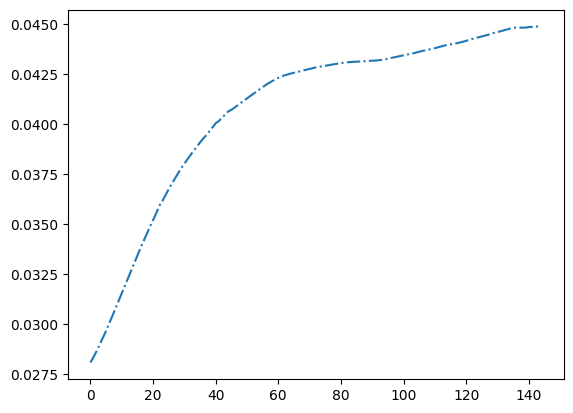

In [165]:
plt.plot(np.mean(raw_gamma_S_preds.detach().cpu().numpy(), 0)[:, 1], "-.")

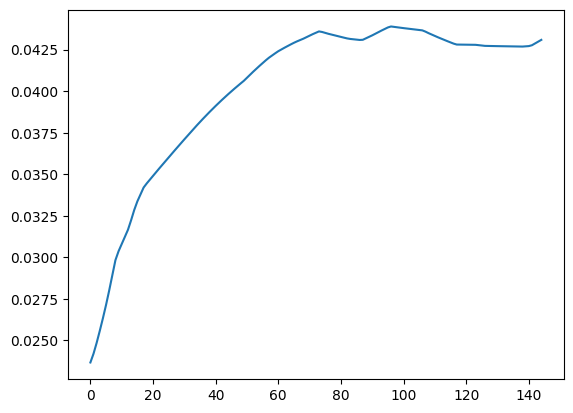

In [166]:
plt.plot(new_forward(model, X_raw_windowed[0]).detach().cpu()[:, 1])

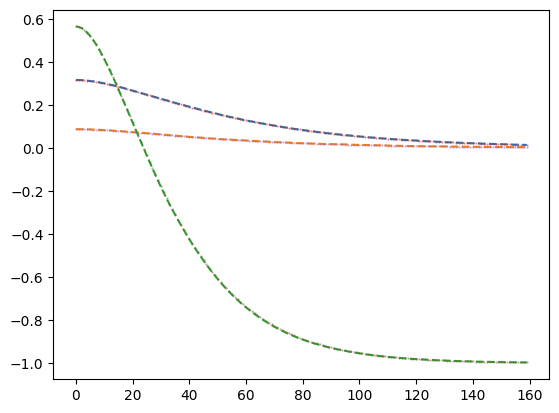

In [212]:
i = np.random.randint(0, 50 - 1)


plt.plot(all_preds[i].T, "--")
plt.plot(X_raw[i].T.to(device), ".", alpha=0.6, ms=1)

In [48]:
all_preds.shape

(100, 3, 160)

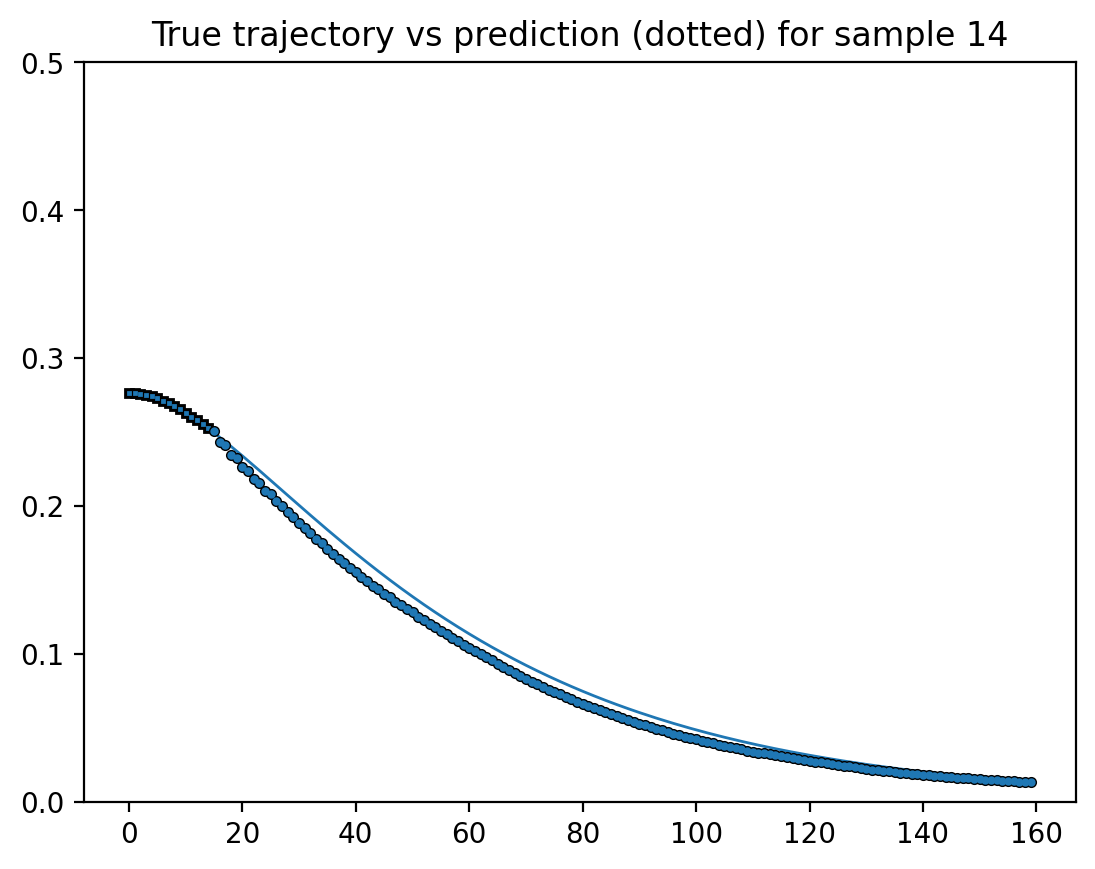

In [64]:
# all_preds = model(tensor(X_val).to(device)).cpu().detach().numpy()

i = np.random.randint(0, 20 - 1)

plt.figure(dpi=200)
for j in range(all_true.shape[1]):
    plt.plot(X_raw[i][j], color=f"C{j}", lw=1)

    plt.plot(
        range(kernel_window),
        all_preds[i][j][:kernel_window],
        "s",
        color=f"k",
        ms=3,
    )
    plt.plot(
        range(kernel_window),
        all_preds[i][j][:kernel_window],
        "s",
        color=f"C{j}",
        ms=1,
    )

    plt.plot(
        range(kernel_window, len(all_preds[i][j])),
        all_preds[i][j][kernel_window:],
        ".",
        color=f"k",
        ms=6,
    )
    plt.plot(
        range(kernel_window, len(all_preds[i][j])),
        all_preds[i][j][kernel_window:],
        ".",
        color=f"C{j}",
        ms=4,
    )

    plt.ylim(0, 0.5)
plt.title(f"True trajectory vs prediction (dotted) for sample {i}")
plt.show()